In [1]:
import json

from utils import read_lines

In [2]:
PATH = json.load(open('path_config.json'))

#### Read XSum

In [3]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Evaluate Annotated Dataset

In [4]:
from tqdm import tqdm

In [5]:
data = json.load(open('../data/annotated_with_probability.json', 'r'))
print(len(data))

180


In [6]:
data[55]

{'id': 10943,
 'pred': "A powerful cyclone has killed at least 11 people and injured more than 100 in Vanuatu, the Pacific nation's president has said.",
 'ents': [{'start': 30,
   'end': 41,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'at least 11',
   'bart.large': 0.0215301513671875,
   'bart.large.xsum': 0.0200347900390625},
  {'start': 61,
   'end': 74,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'more than 100',
   'bart.large': 0.05804443359375,
   'bart.large.xsum': 0.06317138671875},
  {'start': 78,
   'end': 85,
   'label': 0,
   'type': 'GPE',
   'ent': 'Vanuatu',
   'bart.large': 0.00024771690368652344,
   'bart.large.xsum': 0.736328125},
  {'start': 91,
   'end': 98,
   'label': 1,
   'type': 'LOC',
   'ent': 'Pacific',
   'bart.large': 0.59765625,
   'bart.large.xsum': 0.59375}],
 'hallucinations': ['killed at least 11 people and injured more than 100',
  "the Pacific nation's president has said."]}

#### Prior/Posterior Distribution Diagram

In [7]:
%matplotlib inline

from draw import plot_scatter

In [8]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        e['prior'] = e['cnndm_cmlm_cedar']
        e['posterior'] = e['xsum_cmlm_bos']
        prior_posterior.append(e)

KeyError: 'cnndm_cmlm_cedar'

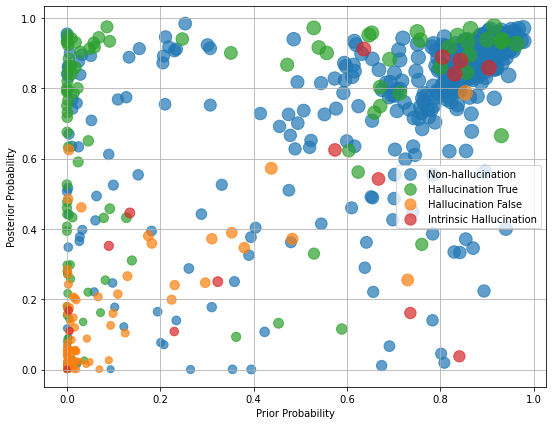

In [9]:
input_data = [
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]
]
labels = ['Non-hallucination', 'Hallucination True', 'Hallucination False', 'Intrinsic Hallucination']
plot_scatter(input_data, labels)

In [10]:
# for p in prior_posterior:
#     if p['prior'] > 0.9:
#         print(p)

#### Evaluate Baseline Model

In [11]:
from sklearn.metrics import classification_report

In [12]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'cnndm_cmlm_cedar': 0.80859375,
 'xsum_cmlm_bos': 0.019073486328125,
 'id': 8805,
 'prior': 0.80859375,
 'posterior': 0.019073486328125}

In [13]:
true_label, factual_label, hallucination_label = [], [], []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        if p['label'] == 0 or p['label'] == 1:
            factual_label.append(1)
        elif p['label'] == 2:
            factual_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 2 or p['label'] == 1:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        true_label.append(p['label'])
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [14]:
lm_baseline_preds = []
overlap_preds = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            overlap_preds.append(1)
        else:
            overlap_preds.append(0)

        if p['posterior'] > p['prior']:
            lm_baseline_preds.append(1)
        else:
            lm_baseline_preds.append(0)

In [15]:
print(classification_report(factual_label, overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.3649    0.9390    0.5256        82
     Factual     0.9882    0.7581    0.8580       554

    accuracy                         0.7814       636
   macro avg     0.6766    0.8486    0.6918       636
weighted avg     0.9079    0.7814    0.8152       636



In [16]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], overlap_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.8436    0.9519    0.8945       187
    Hallucinated     0.9788    0.9265    0.9519       449

        accuracy                         0.9340       636
       macro avg     0.9112    0.9392    0.9232       636
    weighted avg     0.9391    0.9340    0.9350       636



In [17]:
print(classification_report(factual_label, lm_baseline_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.0773    0.2073    0.1126        82
     Factual     0.8438    0.6336    0.7237       554

    accuracy                         0.5786       636
   macro avg     0.4605    0.4204    0.4181       636
weighted avg     0.7449    0.5786    0.6449       636



In [18]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], lm_baseline_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.1364    0.1604    0.1474       187
    Hallucinated     0.6226    0.5768    0.5988       449

        accuracy                         0.4544       636
       macro avg     0.3795    0.3686    0.3731       636
    weighted avg     0.4796    0.4544    0.4661       636



### KNN

In [19]:
import numpy as np
import matplotlib

from sklearn import neighbors
from draw import plot, plot_three

In [20]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [21]:
hallucination_label_reverse = [1 if i == 0 else 0 for i in hallucination_label]
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, hallucination_label_reverse, n_neighbors=12)
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.7121    0.7540    0.7325       187
Non-hallucinated     0.8950    0.8731    0.8839       449

        accuracy                         0.8381       636
       macro avg     0.8035    0.8135    0.8082       636
    weighted avg     0.8412    0.8381    0.8394       636



In [22]:
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, factual_label, n_neighbors=10)
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.5638    0.6463    0.6023        82
     Factual     0.9465    0.9260    0.9361       554

    accuracy                         0.8899       636
   macro avg     0.7552    0.7862    0.7692       636
weighted avg     0.8972    0.8899    0.8931       636



In [23]:
font = {'weight' : 'bold',
        'size'   : 8}

matplotlib.rc('font', **font)

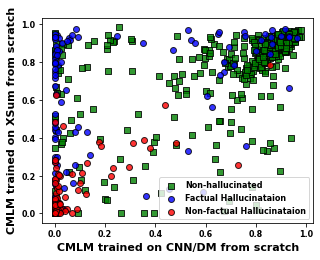

In [24]:
plot_three('entity_distribution_2cmlm',
           posterior_probabilities, prior_probabilities, true_label,
           colors=['green', 'blue', 'red'],
           legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
           n_neighbors=10,
           fig_size=(4.5, 3.5))

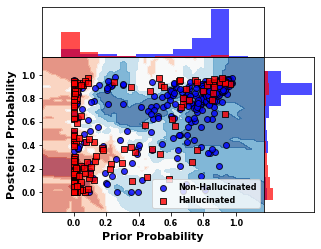

In [25]:
plot('Hallucination Entity Classification',
     posterior_probabilities, prior_probabilities, [1 if i == 0 else 0 for i in hallucination_label], 
     n_neighbors=12, fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Hallucinated', 'Non-Hallucinated'])

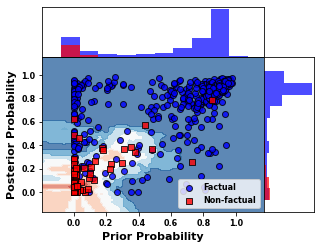

In [26]:
plot('compare_mlm_and_cmlm', posterior_probabilities, prior_probabilities, factual_label, n_neighbors=12, 
     fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Non-factual', 'Factual'])

#### Save KNN Model

In [27]:
import pickle

In [28]:
def build_KNN(posteriors, priors, labels, n_neighbors=15):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    priors = np.array(priors)
    posteriors = np.array(posteriors)
    
#     x_mat = np.vstack([posteriors / np.std(posteriors), priors / np.std(priors)]).transpose()
    x_mat = np.vstack([posteriors, priors]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat, y_vec)
    
    return classifier

In [29]:
knn_classifier = build_KNN(posterior_probabilities, prior_probabilities, hallucination_label_reverse, n_neighbors=3)

In [30]:
preds = knn_classifier.predict(np.array(np.vstack([posterior_probabilities, prior_probabilities]).transpose()))

In [31]:
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.5638    0.6463    0.6023        82
     Factual     0.9465    0.9260    0.9361       554

    accuracy                         0.8899       636
   macro avg     0.7552    0.7862    0.7692       636
weighted avg     0.8972    0.8899    0.8931       636



In [32]:
# source, destination
# pickle.dump(knn_classifier, open('classifiers/knn_correct_cmlm_cmlm.pkl', 'wb') )

#### AUC

In [33]:
from draw import draw_auc

In [34]:
p1, p2, p3, p4, p5, p6 = [], [], [], [], [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        p1.append(p['cnndm_cmlm_cedar'])
        p2.append(p['xsum_cmlm_bos'])
#         p3.append(p['xsum_cmlm_scratch_cedar_warmup_10000'])
#         p4.append(p['bart.large'])
#         p5.append(p['cnndm_cmlm_scratch_cedar_warmup_20000'])
#         p6.append(p['bart.large.xsum'])

assert len(p1) == len(factual_label)

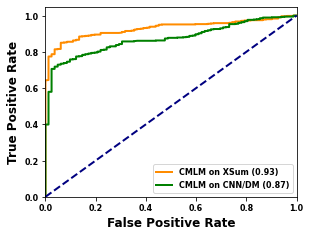

In [35]:
draw_auc(factual_label, [p2, p1], ['CMLM on XSum', 'CMLM on CNN/DM'], ['darkorange', 'green'])